## Frozen Lake with Q-Learning

### Setup

First step: find course helpers library and update `sys.path` to find it.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, subprocess

repo_url = "https://github.com/anton-dergunov/hugging-face-deep-rl.git"
target_dir = "hugging-face-deep-rl"
local_src = os.path.abspath("../src")

if os.path.isdir(local_src):
    repo_root = os.path.abspath("..")
    print("✅ Using local source for course helpers")
else:
    if not os.path.exists(target_dir):
        subprocess.run(["git", "clone", repo_url, target_dir], check=True)
    repo_root = os.path.abspath(target_dir)
    print("✅ Cloned repo with course helpers")

src_path = os.path.join(repo_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"🔧 sys.path updated with: {src_path}")

✅ Using local source for course helpers
🔧 sys.path updated with: /Users/anton/Dropbox/src/hugging-face-deep-rl/src


In [3]:
from rlcourse.system_setup import setup_env
setup_env()

🔧 Bootstrapping environment...
✅ swig already installed


📦 Packages installed
🔇 Warnings filtered
✅ Environment ready


In [ ]:
import gymnasium as gym

from rlcourse import gymnasium_utils

### Environment

[Frozen lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/): the task is to cross the lake from start (position [0,0] on the 2D grid) to the goal (last row, last column) without falling into any holes.

Some of the parameters of the environment:
- `map_name`: "4x4" or "8x8", loads a predefined map of the corresponding size
- `desc`: specfies custom map
- `is_slippery`: if true, then the player may "slip" and not always move in the indended direction

**Action space**: a number in the range `{0, 3}`:
- 0: move left
- 1: move down
- 2: move right
- 3: move up

**Observation space**: a value representing the player's current position as `current_row * ncols + current_col`.

**Rewards**:
- +1 for reaching the goal
- 0 for reaching a hole or a frozen cell

**Episode ends when**:
- Player moves into a hole
- Player reahes the goal
- Length of the episode is 100 (for "4x4" map) or 200 (for "8x8" map)

In [13]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")

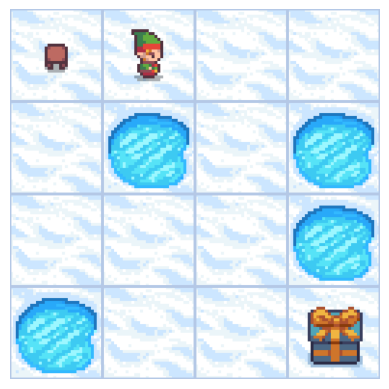

In [14]:
gymnasium_utils.show_environment(env)

In [12]:
gymnasium_utils.describe_environment(env)

hello___
Observation Space:
  Discrete(n=16)
  Example observation: 9

Action Space:
  Discrete(n=4)
  Example action: 1

Max episode steps: 100


### Q-Learning

Involves training Q-Function $Q(s,a)$ of a state $s$ and action $a$ in that state. It is encoded by a Q-Table.

**Hyperparameters**:
- $\alpha$ — learning rate (e.g. $0.1$)  
- $\gamma$ — discount factor (e.g. $0.99$)  
- $\epsilon$ — exploration probability for $\epsilon$-greedy, or $\epsilon$-decay

**Algorithm**:

1. Initialize $Q(s,a)$ arbitrarily for all states $s$ and actions $a$ (e.g. zeros).
2. For each episode:
   1. Initialize starting state $s$.
   2. Repeat until $s$ is terminal:
      - Choose action $a$ from $s$ using an **$\epsilon$-greedy** policy derived from $Q$.
      - Take action $a$, observe reward $r$ and next state $s'$.
      - Update:
        $$
        Q(s, a) \leftarrow Q(s, a) + \alpha\Big(r + \gamma \max_{a'} Q(s', a') - Q(s, a)\Big)
        $$
      - Set $s \leftarrow s'$.